In [71]:
import sys
sys.path.append("/auto/homes/fav25/jax/")

import jax.numpy as np
# import autograd.numpy
# import numpy as np

from SC_IPFP.sde_solvers import solve_sde_RK
from SC_IPFP.utils import log_kde_pdf_per_point, silvermans_rule

from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax, Sigmoid, Tanh
import numpy.random as npr
import jax
from tqdm.notebook import tqdm



import itertools
from functools import partial
# np = jax.numpy
import matplotlib.pyplot as plt
# np = autograd.numpy

In [79]:
class cIPFP(object):
    
    def __init__(self, X_0, X_1, weights=[100], batch_size=None,  rng = jax.random.PRNGKey(0), 
                nrng = npr.RandomState(0), number_time_steps=16, sde_solver=solve_sde_RK, sigma_sq=1, 
                step_size = 0.001, num_epochs = 10, momentum_mass = 0.9, create_network=None):
        
        self.sde_solver = sde_solver
        
        self.number_time_steps = number_time_steps
        self.dt = 1.0 / number_time_steps
        
        
        self.batch_size_f = X_0.shape[0] if batch_size is None else batch_size
        self.batch_size_b = X_1.shape[0] if batch_size is None else batch_size
        
        
        self.X_0 = X_0
        self.X_1 = X_1
        
        self.H_0 = silvermans_rule(X_0)
        self.H_1 = silvermans_rule(X_1)
        
        _, self.dim = self.X_0.shape
        
        create_net = self.create_network if  create_network is None else create_network
        
        self.b_forward_init, self.b_forward = create_net(
            self.dim, weights
        )
        self.b_backward_init, self.b_backward = create_net(
            self.dim, weights
        )
        
        self.sigma = (lambda X,t: sigma_sq)
        
        self.rng = rng
        self.nrng = nrng
        
        self.opt_init_f, self.opt_update_f, self.get_params_f = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        self.opt_init_b, self.opt_update_b, self.get_params_b = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        num_complete_batches_f, leftover_f = divmod(self.X_0.shape[0], self.batch_size_f)
        self.num_batches_f = num_complete_batches_f + bool(leftover_f)
                                               
        num_complete_batches_b, leftover_b = divmod(self.X_1.shape[0], self.batch_size_b)
        self.num_batches_b = num_complete_batches_b + bool(leftover_b)
        
        self.theta_f = None
        self.theta_b = None
        
    
    @staticmethod
    def create_network(dim, weights):
        
        model  = []
        for weight in weights:
            model.append(
                Dense(weight)
            )
                        
            model.append(
                Tanh
            )
            
        
        model.append(Dense(dim))
    
        init_random_params, predict = stax.serial(
           *model
        )
        return init_random_params, predict
        
    @partial(jit, static_argnums=(0,2,3, 6))
    def loss_for_trajectory(self, Xt, b_f, b_b, dt, theta, forwards):
        n_, *_ = Xt.shape
        
#         def b_f(X):
#             T = t.repeat(n_).reshape(n_,1)
#             X = np.concatenate((X,T), axis=1)
#             return alfa(theta, X)
        
        
        if not forwards : Xt = Xt[: , ::-1, :]
        
#         = self.theta_f
#         = self.theta_b
        if forwards:
            b_minus  = b_b(self.theta_b, Xt)
            b_plus = b_f(theta, Xt)
        else:
            b_minus  = b_b(theta, Xt)
            b_plus = b_f(self.theta_f, Xt)
            
        delta_Xt = Xt[:, :-1, :]  - Xt[:, 1:, :]
        
        sign = 1.0 if forwards else -1.0
        
        ito_integral = sign *  (b_plus[:, 1:,:] - b_minus[:, :-1,:])  * delta_Xt
        
        time_integral = sign *  (b_plus**2 - b_minus**2) * dt # Not sure about this dt here
        
        return ito_integral.sum(axis=(1,2)) - 0.5 * time_integral.sum(axis=(1,2))
        
    def data_stream(self, forward=True):
        rng = self.nrng
        X = self.X_0 if forward else self.X_1
        
        batch_size = self.batch_size_f if forward else self.batch_size_b
        num_batches = self.num_batches_f if forward else self.num_batches_b
        
        num_train = self.X_0.shape[0] if forward else self.X_1.shape[0]
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield X[batch_idx] 
        
    @staticmethod
    def sample_trajectory(X, dt, theta, sigma, b, N, sde_solver, forwards=True):
        return sde_solver(alfa=b, beta=sigma,
                          dt=dt, X0=X,
                          N=N, theta=theta)

#     @partial(jit, static_argnums=(0,6,7,8,9,10,11))
    def inner_loss_jit(self, terminal_index, theta, batch, dt, 
                       batch_terminal_empirical, H , b_forward,
                       b_backward, sigma, N, sde_solver, forwards):
        
        b = (b_forward if forwards else (lambda X, theta: -b_backward(X, theta)))
        
        t, Xt = cIPFP.sample_trajectory(batch, dt, theta,  sigma, b, N, sde_solver, forwards)
        cross_entropy = -log_kde_pdf_per_point(Xt[:,-1,:], batch_terminal_empirical, H)
        main_term = self.loss_for_trajectory(Xt, b_forward, b_backward, dt, theta, forwards)

        J = np.mean(main_term + cross_entropy )
        J = np.squeeze(J)
        return J
    
#     @partial(jit, static_argnums=(0,2))
    def transport_batch(self, batch_x, forwards):
        theta = self.theta_f if forwards else self.theta_b    
        b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

        t, Xt = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, 
            X0=batch_x.reshape(-1,self.dim), N=self.number_time_steps, theta=theta
        )

        return Xt[:,-1,:]
    
    def inner_loss(self, theta, batch, forwards=True):
                       
        terminal_index = -1 if forwards else 0
        X_terminal_empirical = next(self.data_stream(forward=not(forwards)))
    
        H = self.H_1 if forwards else self.H_0
        return self.inner_loss_jit(
            terminal_index, theta, batch, self.dt, 
            X_terminal_empirical, H , self.b_forward,
            self.b_backward, self.sigma, self.number_time_steps, self.sde_solver, forwards
        )

    @partial(jit, static_argnums=(0,1, 4))
    def update(self, i, opt_state, batch, forwards=True):

        get_params = self.get_params_f if forwards else self.get_params_b
        params = get_params(opt_state)
        
        gradient = grad(self.inner_loss)(params, batch, forwards)
    
        opt_update  = self.opt_update_f if forwards else self.opt_update_b
        return opt_update(i, gradient, opt_state)

    def fit(self, IPFP_iterations=10, sub_iterations=10):     
        
        _, init_params_f = self.b_forward_init(self.rng, (-1, self.dim))                                             
        opt_state_f = self.opt_init_f(init_params_f)
        
        _, init_params_b = self.b_backward_init(self.rng, (-1, self.dim))                                               
        opt_state_b = self.opt_init_b(init_params_b)
        
        batches_f = self.data_stream(forward=True)
        batches_b = self.data_stream(forward=False)
        
        loss_f, loss_b = [], []
        
        self.theta_f = self.get_params_f(opt_state_f)
        self.theta_b = self.get_params_b(opt_state_b)
        
        try:
            for i in tqdm(range(IPFP_iterations)):

                itercount = itertools.count()

                for k in range(sub_iterations):
                    for _ in range(self.num_batches_b):
    #                     print(_)
                        batch_b =  next(batches_b)
                        opt_state_b  = self.update(
                            next(itercount), opt_state_b, batch_b, False
                        )

                    params = self.get_params_b(opt_state_b)
                    lossb = self.inner_loss(params, batch_b, False)
                    print(f"loss b {lossb}")
                loss_b.append(lossb)

                self.theta_b = self.get_params_b(opt_state_b)

                itercount = itertools.count()

                for k in range(sub_iterations):
                    for _ in range(self.num_batches_f):
    #                     print(_)
                        batch_f =  next(batches_f)
                        opt_state_f = self.update(
                            next(itercount), opt_state_f, next(batches_f), True
                        )
                    params = self.get_params_f(opt_state_f)
                    lossf = self.inner_loss(params, batch_f, True)
                    print(f"loss f {lossf}")
                loss_f.append(lossf)


                self.theta_f = self.get_params_f(opt_state_f)
                self.loss_f = loss_f
                self.loss_b = loss_b
        except:
            pass
        
        plt.plot(range(IPFP_iterations), loss_f, "g")
        plt.show()
        plt.plot(range(IPFP_iterations), loss_b, "b")
        plt.show()
            

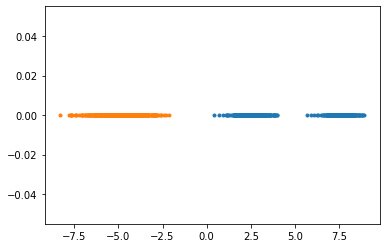

In [80]:
n = 500
n_2 = int(n * 0.5)

X1 = npr.randn(n).reshape(-1,1) - 5
X21 = 0.6 * npr.randn(n_2).reshape(-1,1) + 7.5
X22 =  0.6 * npr.randn(n_2).reshape(-1,1) + 2.5
X2 = np.concatenate((X21, X22), axis=0)

plt.plot(X2.flatten(), [0] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

In [81]:
c = cIPFP(X1, X2,  number_time_steps=100, batch_size=150 , step_size = 0.001, weights=[100,100])

In [59]:
 _, init_params_f = c.b_forward_init(c.rng, (-1, c.dim))                                             
opt_state_f = c.opt_init_f(init_params_f)


theta_f = c.get_params_f(opt_state_f)

In [60]:
theta_f[0][1].shape, theta_f[1]

((500,), ())

In [61]:
t, Xt = c.sample_trajectory(X1[0].reshape(-1,1),c.dt,  theta_f,  c.sigma, c.b_forward, c.number_time_steps, c.sde_solver, True)

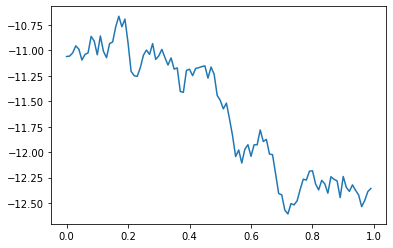

In [62]:
import matplotlib.pyplot as plt

plt.plot(t, Xt.flatten())

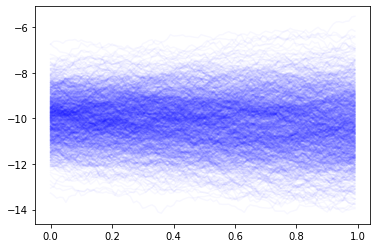

In [63]:
for x1 in X1:
    t, Xt = c.sample_trajectory(x1.reshape(1,-1),c.dt,  theta_f,  c.sigma, c.b_forward, c.number_time_steps, c.sde_solver)
    plt.plot(t.flatten(), Xt.flatten(), 'b', alpha=0.03, )

In [289]:
import numpy as onp
import jax.numpy as np

X0 = np.array(X1[0,:])
t0=0

alfa  = c.b_forward 
beta = c.sigma
randn = onp.random.randn
dt = c.dt
N= c.number_time_steps
theta = theta_f


if alfa is None or beta is None:
    raise ValueError("Error: SDE not defined.")


X0 = randn(*alfa(0, 0).shape) if X0 is None else np.array(X0)
#     DW = (lambda Y, dt: randn((len(X0))) * np.sqrt(dt)) if DW is None else DW
DWs  = randn(N-1, len(X0))  * np.sqrt(dt)



Y, ti = np.zeros((N, len(X0))), np.arange(N)*dt + t0
Y = jax.ops.index_update(Y, jax.ops.index[0,:],  X0)



In [14]:
loss= c.loss_for_trajectory(Xt, c.b_forward, c.b_backward, c.dt, theta_f, True)

In [15]:
cross_entropy = log_kde_pdf_per_point(Xt[-1].reshape(-1,1), X2, c.H_0)

In [16]:
%%time
c.inner_loss(theta_f, X1, True)

CPU times: user 752 ms, sys: 10.3 ms, total: 762 ms
Wall time: 810 ms


DeviceArray(61.630344, dtype=float32)

In [17]:
%%time
c.inner_loss(theta_f, X1, True)

CPU times: user 16.8 ms, sys: 55 µs, total: 16.8 ms
Wall time: 10.5 ms


DeviceArray(68.25656, dtype=float32)

In [75]:

# _, init_params_f = c.b_forward_init(c.rng, (-1, c.dim))                                             
# opt_state_f = c.opt_init_f(init_params_f)

# _, init_params_b = c.b_backward_init(c.rng, (-1, c.dim))                                               
# opt_state_b = c.opt_init_b(init_params_b)

# batches_f = c.data_stream(forward=True)
# batches_b = c.data_stream(forward=False)

# c.update(0, opt_state_b, next(batches_b), forwards=False)
KeyboardInterrupt

KeyboardInterrupt

In [295]:
from jax import grad


In [18]:
%%time
gradient = jit(grad(c.inner_loss), static_argnums=(2))
kek = gradient(theta_f, X1, True)
# partial(jit, static_argnums=(2))(gradient)

CPU times: user 2.81 s, sys: 25.1 ms, total: 2.84 s
Wall time: 3.39 s


In [55]:
%%time
kek = gradient(theta_f, X1, True)

loss b 4222.2470703125
loss f 198.9703826904297



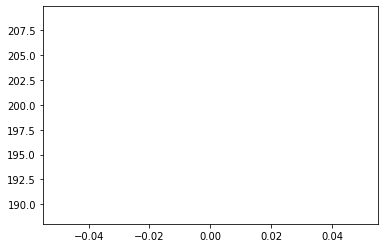

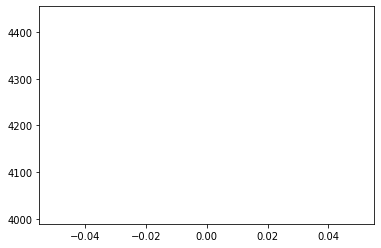

CPU times: user 52.7 s, sys: 1.06 s, total: 53.8 s
Wall time: 51.5 s


In [64]:
%%time
c.fit(1,1)

loss b 5198.12890625
loss f 190.79080200195312



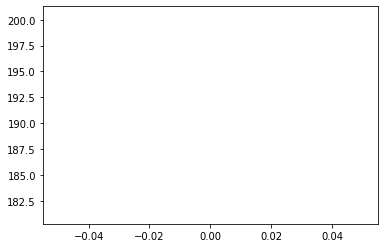

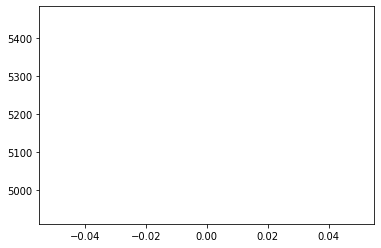

CPU times: user 3.6 s, sys: 1.57 s, total: 5.18 s
Wall time: 3.25 s


In [65]:
%%time
c.fit(1,1)

loss b 330.9650573730469
loss b 153.12489318847656
loss b 88.19586181640625
loss b 36.09007263183594
loss b 28.312334060668945
loss b 35.141326904296875
loss b -6.30498743057251
loss b 2.766981601715088
loss b 11.913827896118164
loss b -28.24493980407715
loss b -3.6730637550354004
loss b -26.96272850036621
loss b -21.819318771362305
loss b -16.88233757019043
loss b -41.04996871948242
loss b -14.038064002990723
loss b -19.92167091369629
loss b -53.173038482666016
loss b -62.056007385253906
loss b -60.4093017578125
loss b -35.29047775268555
loss b -41.588356018066406
loss b -52.831825256347656
loss b -51.87819290161133
loss b -66.93482971191406
loss b -71.07965087890625
loss b -84.72640991210938
loss b -62.54116439819336
loss b -78.95793151855469
loss b -105.41666412353516
loss f 107.89742279052734
loss f 39.606468200683594
loss f -6.275331974029541
loss f -27.340410232543945
loss f -39.64445114135742
loss f -49.53507614135742
loss f -56.821739196777344
loss f -60.43102264404297
loss f -

loss b -771.4321899414062
loss b -775.53955078125
loss b -803.345458984375
loss b -797.2120361328125
loss b -784.5546264648438
loss b -800.5416870117188
loss b -798.0571899414062
loss b -865.6561889648438
loss b -779.391357421875
loss b -810.3739013671875
loss b -812.9111938476562
loss b -857.1253051757812
loss b -850.0173950195312
loss b -842.4132080078125
loss b -850.3400268554688
loss b -946.2203979492188
loss f -282.9945983886719
loss f -287.2362060546875
loss f -285.6624450683594
loss f -283.8552551269531
loss f -290.2414245605469
loss f -285.36444091796875
loss f -274.3862609863281
loss f -291.7991943359375
loss f -289.1002197265625
loss f -284.889892578125
loss f -289.5120849609375
loss f -295.671142578125
loss f -293.6456604003906
loss f -297.0556945800781
loss f -286.65533447265625
loss f -296.28009033203125
loss f -282.23004150390625
loss f -297.846435546875
loss f -295.65081787109375
loss f -297.1248779296875
loss f -292.5784912109375
loss f -308.2259216308594
loss f -307.42

loss f -2198.925537109375
loss f -2202.88720703125
loss f -2208.600341796875
loss f -2236.4169921875
loss f -2218.392578125
loss f -2257.969970703125
loss f -2276.0068359375
loss f -2282.817626953125
loss f -2285.5947265625
loss f -2308.982666015625
loss f -2335.8408203125
loss f -2320.50048828125
loss f -2337.456787109375
loss f -2386.631103515625
loss f -2401.599853515625
loss f -2409.6171875
loss f -2391.53564453125
loss f -2446.443115234375
loss f -2448.59423828125
loss f -2480.525390625
loss f -2488.12451171875
loss f -2529.568603515625
loss f -2514.43505859375
loss f -2555.501220703125
loss f -2577.315673828125
loss f -2601.04638671875
loss f -2612.570068359375
loss f -2627.586669921875
loss f -2645.495849609375
loss f -2673.267822265625
loss b -1520.0560302734375
loss b -1407.3719482421875
loss b -1462.8665771484375
loss b -1365.5572509765625
loss b -1318.754638671875
loss b -1430.9549560546875
loss b -1390.060791015625
loss b -1501.2208251953125
loss b -1535.691650390625
loss b

loss f -4673.7587890625
loss f -4683.3125
loss f -4654.4072265625
loss f -4671.298828125
loss f -4748.69384765625
loss b -1890.78857421875
loss b -1823.849609375
loss b -1944.740966796875
loss b -1907.56103515625
loss b -1834.6826171875
loss b -1887.5244140625
loss b -2077.933837890625
loss b -2003.9241943359375
loss b -1955.708984375
loss b -1991.29833984375
loss b -1976.448974609375
loss b -2014.7296142578125
loss b -2005.2587890625
loss b -2061.511962890625
loss b -2042.305419921875
loss b -1948.286376953125
loss b -2064.54931640625
loss b -2125.00830078125
loss b -2079.239501953125
loss b -1986.5328369140625
loss b -1955.0836181640625
loss b -2007.42724609375
loss b -1998.4163818359375
loss b -1975.5382080078125
loss b -2020.5391845703125
loss b -2056.1884765625
loss b -1966.9593505859375
loss b -1998.153564453125
loss b -2038.3204345703125
loss b -2092.50634765625
loss f -4700.52783203125
loss f -4713.880859375
loss f -4770.4638671875
loss f -4743.712890625
loss f -4785.048828125


loss b -2578.01806640625
loss f -6637.6474609375
loss f -6701.23828125
loss f -6715.52490234375
loss f -6699.388671875
loss f -6702.33740234375
loss f -6676.6259765625
loss f -6731.3798828125
loss f -6738.7998046875
loss f -6766.64111328125
loss f -6788.298828125
loss f -6816.26025390625
loss f -6744.35009765625
loss f -6808.7666015625
loss f -6803.99658203125
loss f -6811.05126953125
loss f -6861.16552734375
loss f -6846.6884765625
loss f -6890.64306640625
loss f -6873.02685546875
loss f -6861.17919921875
loss f -6900.8154296875
loss f -6959.52587890625
loss f -6948.00048828125
loss f -6960.85498046875
loss f -6980.93359375
loss f -6977.119140625
loss f -7009.58837890625
loss f -6991.49658203125
loss f -7019.39697265625
loss f -7047.7978515625
loss b -2671.338623046875
loss b -2545.49267578125
loss b -2400.032470703125
loss b -2489.925048828125
loss b -2552.83056640625
loss b -2519.048828125
loss b -2579.00732421875
loss b -2660.356689453125
loss b -2694.233642578125
loss b -2566.2263

loss b -3087.897216796875
loss b -3100.685302734375
loss b -3157.426025390625
loss b -3187.89453125
loss b -3109.552001953125
loss b -3113.988037109375
loss b -3031.5654296875
loss b -3113.733642578125
loss b -3195.894287109375
loss b -3248.157958984375
loss b -3111.356689453125
loss b -2833.78662109375
loss b -2997.322509765625
loss b -3113.44677734375
loss b -3162.60888671875
loss b -3155.4287109375
loss b -3183.65087890625
loss b -3052.329345703125
loss b -3168.66796875
loss b -3069.3486328125
loss b -3024.735107421875
loss b -3203.018310546875
loss b -3095.40234375
loss b -3241.1103515625
loss f -9175.8251953125
loss f -9104.671875
loss f -9133.9658203125
loss f -9132.4541015625
loss f -9183.3076171875
loss f -9165.9853515625
loss f -9212.5712890625
loss f -9185.3330078125
loss f -9204.5869140625
loss f -9228.9853515625
loss f -9186.486328125
loss f -9250.2021484375
loss f -9218.0302734375
loss f -9268.3857421875
loss f -9269.2060546875
loss f -9285.3955078125
loss f -9222.48144531

loss f -11456.1123046875
loss f -11507.4990234375
loss f -11472.3076171875
loss f -11495.1572265625
loss f -11498.3955078125
loss f -11539.646484375
loss f -11500.5078125
loss f -11542.4775390625
loss f -11601.5693359375
loss f -11588.255859375
loss f -11579.703125
loss f -11602.5087890625
loss f -11635.9677734375
loss f -11690.1923828125
loss f -11619.4580078125
loss f -11713.7666015625
loss f -11747.5927734375
loss f -11725.1083984375
loss b -3690.6884765625
loss b -3766.62890625
loss b -3584.71044921875
loss b -3685.07080078125
loss b -3523.355224609375
loss b -3805.965087890625
loss b -3786.37109375
loss b -3657.1748046875
loss b -3644.671630859375
loss b -3580.113525390625
loss b -3647.9208984375
loss b -3716.835205078125
loss b -3850.957275390625
loss b -3843.28076171875
loss b -3741.287109375
loss b -3732.736328125
loss b -3873.5927734375
loss b -3696.87841796875
loss b -3726.01953125
loss b -3822.8798828125
loss b -3861.780517578125
loss b -3891.56884765625
loss b -3639.4948730

loss b -4413.06591796875
loss b -4323.099609375
loss b -4406.2333984375
loss b -4276.80322265625
loss b -4311.29736328125
loss b -4261.74267578125
loss b -4370.8447265625
loss b -4404.27197265625
loss b -4316.90380859375
loss b -4332.69677734375
loss b -4500.37939453125
loss f -14066.4658203125
loss f -14100.3408203125
loss f -14135.4140625
loss f -14130.06640625
loss f -14114.8056640625
loss f -14122.46875
loss f -14126.05859375
loss f -14065.8251953125
loss f -14165.900390625
loss f -14163.443359375
loss f -14184.5205078125
loss f -14190.78515625
loss f -14159.7392578125
loss f -14147.138671875
loss f -14232.1923828125
loss f -14192.884765625
loss f -14306.224609375
loss f -14281.791015625
loss f -14324.4658203125
loss f -14287.3583984375
loss f -14370.7451171875
loss f -14357.3916015625
loss f -14346.0205078125
loss f -14414.8291015625
loss f -14425.7578125
loss f -14411.6962890625
loss f -14504.0244140625
loss f -14484.40625
loss f -14524.66015625
loss f -14544.21484375
loss b -431

loss b -5006.91748046875
loss b -4893.03515625
loss b -5066.2080078125
loss b -4870.27978515625
loss b -4874.8857421875
loss b -4920.18017578125
loss b -4760.25341796875
loss b -4793.0341796875
loss b -4947.384765625
loss b -4878.58154296875
loss b -5099.8330078125
loss b -5124.751953125
loss b -5006.14697265625
loss b -5056.9658203125
loss b -4874.41943359375
loss b -4977.38818359375
loss b -4982.9326171875
loss b -4998.3037109375
loss b -4886.4765625
loss b -5047.22021484375
loss b -5149.953125
loss b -4561.306640625
loss b -5205.50537109375
loss b -5111.32275390625
loss b -5024.31103515625
loss b -5121.81103515625
loss b -5090.32275390625
loss b -4974.70751953125
loss b -4957.03857421875
loss b -5127.62060546875
loss f -17074.349609375
loss f -17014.171875
loss f -17111.43359375
loss f -17106.59765625
loss f -17125.810546875
loss f -17072.783203125
loss f -17105.53515625
loss f -17154.091796875
loss f -17128.734375
loss f -17153.71875
loss f -17213.203125
loss f -17160.787109375
los

loss f -20006.203125
loss f -20042.15625
loss f -20066.75
loss f -20085.6640625
loss f -19995.23046875
loss f -20065.6875
loss f -20160.970703125
loss f -20146.83984375
loss f -20142.611328125
loss f -20160.671875
loss f -20257.916015625
loss b -5607.662109375
loss b -5562.408203125
loss b -5497.4873046875
loss b -5969.2705078125
loss b -5540.884765625
loss b -5568.3076171875
loss b -5384.619140625
loss b -5660.24755859375
loss b -5768.62939453125
loss b -5818.72607421875
loss b -5692.01611328125
loss b -5647.74755859375
loss b -5958.1015625
loss b -5788.83203125
loss b -5581.7451171875
loss b -5719.6162109375
loss b -5836.6484375
loss b -5691.58837890625
loss b -5902.52197265625
loss b -5728.9658203125
loss b -5718.1826171875
loss b -5739.4814453125
loss b -5745.7001953125
loss b -5691.61279296875
loss b -5742.7841796875
loss b -5603.40185546875
loss b -6095.93505859375
loss b -5714.89453125
loss b -5985.1513671875
loss b -5897.5498046875
loss f -20260.05078125
loss f -20243.486328125

loss f -23247.013671875
loss f -23269.107421875
loss f -23185.029296875
loss f -23276.69140625
loss f -23344.71875
loss f -23289.91796875
loss f -23336.31640625
loss f -23261.947265625
loss f -23333.318359375
loss f -23369.7578125
loss f -23422.8515625
loss f -23441.84375
loss f -23427.259765625
loss f -23463.33203125
loss f -23452.16015625
loss f -23439.7109375
loss f -23530.037109375
loss f -23557.54296875
loss f -23574.6640625
loss f -23551.783203125
loss f -23628.046875
loss f -23634.509765625
loss b -6478.90234375
loss b -6666.86376953125
loss b -6280.4482421875
loss b -6043.64990234375
loss b -6520.5302734375
loss b -6673.2607421875
loss b -6489.68212890625
loss b -6448.67333984375
loss b -6359.13916015625
loss b -6480.8994140625
loss b -6474.04541015625
loss b -6259.9599609375
loss b -6764.08984375
loss b -6541.423828125
loss b -6533.73046875
loss b -6358.19384765625
loss b -6462.724609375
loss b -6583.12109375
loss b -6457.43359375
loss b -6784.8623046875
loss b -6809.350585937

loss f -26722.72265625
loss f -26687.607421875
loss f -26731.759765625
loss f -26792.6328125
loss f -26666.796875
loss f -26780.44140625
loss f -26850.283203125
loss f -26719.767578125
loss f -26830.224609375
loss f -26749.189453125
loss f -26870.083984375
loss f -26948.97265625
loss f -26946.107421875
loss f -26899.12109375
loss f -26949.8359375
loss f -26967.26953125
loss f -26903.736328125
loss f -27010.486328125
loss f -27009.107421875
loss f -27070.9453125
loss f -27057.49609375
loss f -27067.810546875
loss f -27105.90234375
loss f -27135.998046875
loss f -27118.84765625
loss f -27136.380859375
loss f -27250.619140625
loss f -27339.548828125
loss f -27246.412109375
loss f -27306.9140625
loss b -6964.43359375
loss b -7316.1689453125
loss b -7054.9677734375
loss b -7148.423828125
loss b -7188.4736328125
loss b -7403.1025390625
loss b -7076.62890625
loss b -6816.06787109375
loss b -7193.2958984375
loss b -7224.86083984375
loss b -7052.52490234375
loss b -7195.74462890625
loss b -7257

loss b -7808.75830078125
loss b -7969.576171875
loss b -7793.1826171875
loss b -7942.09033203125
loss b -7930.02880859375
loss b -7892.7841796875
loss b -7772.6015625
loss b -7929.4345703125
loss b -7628.75537109375
loss b -7869.2841796875
loss b -7866.29443359375
loss b -7871.38720703125
loss f -30552.302734375
loss f -30506.75390625
loss f -30629.490234375
loss f -30572.65234375
loss f -30584.17578125
loss f -30643.423828125
loss f -30535.25
loss f -30671.1640625
loss f -30571.587890625
loss f -30697.064453125
loss f -30743.666015625
loss f -30720.640625
loss f -30761.494140625
loss f -30828.806640625
loss f -30802.7421875
loss f -30746.48828125
loss f -30815.380859375
loss f -30880.548828125
loss f -30959.955078125
loss f -30831.51171875
loss f -30983.494140625
loss f -30987.86328125
loss f -31008.1171875
loss f -30998.75
loss f -31069.841796875
loss f -31120.068359375
loss f -31021.6953125
loss f -31124.37109375
loss f -31176.55859375
loss f -31249.55078125
loss b -7853.1650390625


loss b -8738.6064453125
loss b -8418.7666015625
loss b -8652.3984375
loss b -8190.7294921875
loss b -8567.9296875
loss b -8619.46484375
loss b -8416.7646484375
loss b -8336.025390625
loss b -8319.9873046875
loss b -8352.75
loss b -8455.8564453125
loss b -8419.91796875
loss b -8743.0693359375
loss b -8971.91015625
loss b -8673.9775390625
loss f -34655.87109375
loss f -34569.375
loss f -34611.56640625
loss f -34614.06640625
loss f -34620.23046875
loss f -34656.5390625
loss f -34749.03125
loss f -34829.51171875
loss f -34646.3515625
loss f -34758.37890625
loss f -34803.87890625
loss f -34822.3671875
loss f -34683.5078125
loss f -34868.87109375
loss f -34903.5703125
loss f -34813.61328125
loss f -34812.11328125
loss f -34933.3203125
loss f -34958.1640625
loss f -34876.953125
loss f -34966.83984375
loss f -35054.98828125
loss f -35119.26171875
loss f -35071.2734375
loss f -35157.67578125
loss f -35126.43359375
loss f -35147.8828125
loss f -35350.29296875
loss f -35219.56640625
loss f -35203

loss b -9003.2783203125
loss b -8875.4384765625
loss b -9613.4091796875
loss b -9426.583984375
loss b -9340.4638671875
loss b -9416.5390625
loss b -9113.9326171875
loss b -9527.669921875
loss b -9591.3740234375
loss b -9657.1650390625
loss b -9292.1640625
loss f -38944.640625
loss f -39006.67578125
loss f -38966.26171875
loss f -38961.29296875
loss f -39010.49609375
loss f -39057.55859375
loss f -39016.9296875
loss f -39024.90234375
loss f -39048.65234375
loss f -39078.4296875
loss f -39104.8984375
loss f -39137.8046875
loss f -39169.62890625
loss f -39157.2578125
loss f -39286.1328125
loss f -39179.796875
loss f -39301.20703125
loss f -39162.21875
loss f -39307.16015625
loss f -39329.2265625
loss f -39310.4375
loss f -39413.76171875
loss f -39404.47265625
loss f -39443.859375
loss f -39526.85546875
loss f -39504.734375
loss f -39564.76953125
loss f -39514.73828125
loss f -39415.48046875
loss f -39553.2265625
loss b -8741.9189453125
loss b -9301.6611328125
loss b -9667.4716796875
loss 

loss b -9848.30859375
loss b -9865.9609375
loss b -10114.3466796875
loss b -10069.3837890625
loss b -9850.625
loss b -9655.431640625
loss b -10267.16796875
loss b -10504.4775390625
loss f -43287.62890625
loss f -43501.93359375
loss f -43336.13671875
loss f -43469.515625
loss f -43467.10546875
loss f -43620.52734375
loss f -43547.484375
loss f -43514.21875
loss f -43585.59375
loss f -43671.5859375
loss f -43601.6953125
loss f -43624.72265625
loss f -43677.5078125
loss f -43671.8359375
loss f -43756.55078125
loss f -43648.69921875
loss f -43734.1328125
loss f -43767.3828125
loss f -43926.3828125
loss f -43929.09765625
loss f -43994.0625
loss f -43776.96484375
loss f -43934.55859375
loss f -43923.97265625
loss f -43786.2890625
loss f -43904.51171875
loss f -44110.35546875
loss f -44183.265625
loss f -44138.8515625
loss f -44081.12109375
loss b -10210.126953125
loss b -10094.12109375
loss b -10232.0009765625
loss b -9927.3515625
loss b -10185.5595703125
loss b -9899.9619140625
loss b -9673

loss b -9504.8134765625
loss b -9032.6240234375
loss b -9140.095703125
loss b -9912.65234375
loss b -9789.31640625
loss f -48228.9765625
loss f -48215.62109375
loss f -48312.5234375
loss f -48198.87109375
loss f -48287.33984375
loss f -48210.93359375
loss f -48321.38671875
loss f -48328.10546875
loss f -48298.07421875
loss f -48575.41796875
loss f -48284.54296875
loss f -48490.7578125
loss f -48398.16015625
loss f -48531.41796875
loss f -48446.14453125
loss f -48551.55859375
loss f -48515.67578125
loss f -48561.41796875
loss f -48653.546875
loss f -48671.1875
loss f -48570.65625
loss f -48730.9375
loss f -48802.92578125
loss f -48542.5390625
loss f -48682.57421875
loss f -48616.27734375
loss f -48746.59375
loss f -48888.10546875
loss f -48954.4765625
loss f -48612.6484375
loss b -9125.04296875
loss b -9247.5673828125
loss b -9908.2451171875
loss b -9821.478515625
loss b -9433.4541015625
loss b -9585.34375
loss b -9679.9482421875
loss b -9608.419921875
loss b -9006.2060546875
loss b -94

loss b -9287.5146484375
loss f -52994.98828125
loss f -53091.05078125
loss f -53209.765625
loss f -53151.9765625
loss f -53066.8203125
loss f -53176.25
loss f -53331.55859375
loss f -53375.11328125
loss f -53375.3671875
loss f -53468.26953125
loss f -53445.34765625
loss f -53494.1796875
loss f -53484.46484375
loss f -53416.2421875
loss f -53401.31640625
loss f -53492.53515625
loss f -53627.078125
loss f -53486.99609375
loss f -53559.62109375
loss f -53650.2890625
loss f -53561.98046875
loss f -53684.8828125
loss f -53743.65625
loss f -53788.44921875
loss f -53437.62109375
loss f -53920.27734375
loss f -53854.515625
loss f -53841.06640625
loss f -53779.95703125
loss f -53884.08984375
loss b -9469.4609375
loss b -9647.3603515625
loss b -9495.9755859375
loss b -9805.8349609375
loss b -9702.4873046875
loss b -9527.34765625
loss b -9734.224609375
loss b -9356.8701171875
loss b -9636.814453125
loss b -9389.59375
loss b -9500.8583984375
loss b -10052.3505859375
loss b -9404.505859375
loss b -

loss f -58457.74609375
loss f -58476.46875
loss f -58466.34765625
loss f -58308.6875
loss f -58402.41015625
loss f -58579.28515625
loss f -58618.6171875
loss f -58477.765625
loss f -58483.296875
loss f -58612.640625
loss f -58605.12890625
loss f -58617.7265625
loss f -58590.18359375
loss f -58630.76953125
loss f -58912.09765625
loss f -58686.5625
loss f -58817.421875
loss f -58793.08984375
loss f -58734.73828125
loss f -58757.15234375
loss f -58846.4765625
loss f -59097.14453125
loss f -58878.86328125
loss f -58984.6875
loss f -59103.40234375
loss f -58913.0078125
loss f -59045.3359375
loss f -59064.1484375
loss b -9561.28515625
loss b -9154.1748046875
loss b -9956.1044921875
loss b -9556.0869140625
loss b -9721.2001953125
loss b -9474.521484375
loss b -10134.1220703125
loss b -9423.21484375
loss b -9566.513671875
loss b -9697.83203125
loss b -9655.23828125
loss b -9434.9287109375
loss b -9939.24609375
loss b -9838.888671875
loss b -9312.283203125
loss b -10118.3857421875
loss b -10208

loss f -63815.515625
loss f -63712.62109375
loss f -63902.94921875
loss f -63860.578125
loss f -63825.1875
loss f -63605.15234375
loss f -63761.28125
loss f -63762.66015625
loss f -63936.84375
loss f -63954.02734375
loss f -64172.16796875
loss f -64329.0625
loss f -64359.12890625
loss f -64378.015625
loss f -64314.515625
loss f -64339.671875
loss f -64532.1484375
loss f -64268.48828125
loss f -64123.77734375
loss f -64066.58984375
loss f -64454.7421875
loss f -64706.7265625
loss f -64504.58203125
loss f -64632.859375
loss b -9654.2705078125
loss b -9508.0908203125
loss b -9661.2548828125
loss b -9294.5986328125
loss b -9559.8701171875
loss b -9534.2705078125
loss b -10127.08203125
loss b -10089.3955078125
loss b -9647.4521484375
loss b -9519.9423828125
loss b -9737.11328125
loss b -10065.546875
loss b -9797.2451171875
loss b -10014.787109375
loss b -9310.388671875
loss b -10269.8466796875
loss b -9439.181640625
loss b -9465.3759765625
loss b -9538.765625
loss b -9371.25
loss b -10056.1

loss f -69812.6328125
loss f -69760.2890625
loss f -69787.9921875
loss f -70030.1328125
loss f -69731.984375
loss f -69931.015625
loss f -69675.9296875
loss f -69982.3046875
loss f -69783.046875
loss f -69833.015625
loss f -69930.7890625
loss f -70294.90625
loss f -70276.34375
loss f -70263.9765625
loss f -70165.4609375
loss b -9282.8994140625
loss b -9535.8623046875
loss b -9696.1923828125
loss b -9480.669921875
loss b -10038.9912109375
loss b -9664.796875
loss b -9330.2841796875
loss b -9820.5927734375
loss b -9650.8564453125
loss b -9150.31640625
loss b -10013.3251953125
loss b -9729.2060546875
loss b -9832.7314453125
loss b -9452.0087890625
loss b -9363.666015625
loss b -10020.8427734375
loss b -9704.83984375
loss b -9855.0732421875
loss b -10187.13671875
loss b -9377.7919921875
loss b -9987.650390625
loss b -10120.6943359375
loss b -10018.2763671875
loss b -9891.8544921875
loss b -9643.0263671875
loss b -9701.8740234375
loss b -9708.5947265625
loss b -9631.3349609375
loss b -10086

loss f -75832.3515625
loss f -75789.015625
loss f -75776.359375
loss f -76213.609375
loss f -75992.21875
loss b -9872.7900390625
loss b -9609.0498046875
loss b -10423.2529296875
loss b -9290.1748046875
loss b -9656.697265625
loss b -9478.953125
loss b -10192.8701171875
loss b -9522.28515625
loss b -9857.1630859375
loss b -9571.6416015625
loss b -9947.865234375
loss b -9842.58984375
loss b -9620.2802734375
loss b -9516.2255859375
loss b -9755.400390625
loss b -9673.7998046875
loss b -10003.1982421875
loss b -10329.9716796875
loss b -9356.9814453125
loss b -9582.7236328125
loss b -9522.068359375
loss b -9281.490234375
loss b -10229.0087890625
loss b -10176.390625
loss b -9953.595703125
loss b -10011.2177734375
loss b -9740.2578125
loss b -9505.08203125
loss b -9904.515625
loss b -9599.7333984375
loss f -76039.5859375
loss f -76376.3828125
loss f -76285.4765625
loss f -76165.40625
loss f -76239.40625
loss f -76273.3828125
loss f -76303.8515625
loss f -76336.1015625
loss f -76152.7109375
l

loss b -9216.0546875
loss b -9880.4208984375
loss b -10144.5439453125
loss b -10074.9169921875
loss b -10461.3740234375
loss b -10044.1416015625
loss b -10060.0419921875
loss b -9755.6923828125
loss b -9514.8046875
loss b -9607.134765625
loss b -9772.55859375
loss b -9900.45703125
loss b -10113.55859375
loss b -10194.7216796875
loss b -9757.9755859375
loss b -10055.3505859375
loss b -10496.3662109375
loss b -9709.98046875
loss b -9575.30078125
loss b -10075.099609375
loss b -9511.7236328125
loss b -9359.82421875
loss b -9434.966796875
loss f -82368.265625
loss f -82222.25
loss f -82302.3984375
loss f -82371.59375
loss f -82311.5625
loss f -82479.859375
loss f -82487.640625
loss f -82344.640625
loss f -82460.75
loss f -82506.6015625
loss f -82495.90625
loss f -82384.4296875
loss f -82647.484375
loss f -82569.59375
loss f -82717.265625
loss f -82613.5078125
loss f -82744.625
loss f -82767.125
loss f -82641.4921875
loss f -82806.5703125
loss f -82873.15625
loss f -82913.8828125
loss f -82

loss b -9878.1552734375
loss b -9795.169921875
loss b -10233.6708984375
loss b -10302.546875
loss b -10227.4130859375
loss b -10322.40234375
loss b -9893.294921875
loss b -9990.5615234375
loss b -10150.7841796875
loss b -9829.029296875
loss b -9944.400390625
loss b -9984.9404296875
loss f -88222.3984375
loss f -88180.0625
loss f -88240.2421875
loss f -88226.859375
loss f -88144.3203125
loss f -88555.8984375
loss f -88585.8828125
loss f -88318.671875
loss f -88533.2421875
loss f -88416.609375
loss f -88559.0703125
loss f -88495.875
loss f -88685.90625
loss f -88666.421875
loss f -88620.0078125
loss f -88872.390625
loss f -88761.71875
loss f -88815.640625
loss f -88953.625
loss f -88832.84375
loss f -88659.578125
loss f -88960.875
loss f -89186.78125
loss f -88897.625
loss f -89152.2109375
loss f -89284.3515625
loss f -89170.5
loss f -88921.5625
loss f -89373.8046875
loss f -89096.90625
loss b -9967.865234375
loss b -9518.7412109375
loss b -9993.755859375
loss b -9876.115234375
loss b -1

loss b -10465.8076171875
loss f -94639.0546875
loss f -95032.375
loss f -94929.9609375
loss f -94920.6953125
loss f -94894.5
loss f -94892.8046875
loss f -94946.953125
loss f -95040.65625
loss f -95112.265625
loss f -95182.0546875
loss f -95173.6328125
loss f -94965.3359375
loss f -95242.6640625
loss f -95020.0234375
loss f -95042.5703125
loss f -95390.1640625
loss f -95117.6640625
loss f -95377.671875
loss f -95066.3203125
loss f -95329.359375
loss f -95070.796875
loss f -95665.6875
loss f -95011.6328125
loss f -95101.2890625
loss f -95671.8984375
loss f -95680.9765625
loss f -95864.296875
loss f -95391.3046875
loss f -95892.9375
loss f -95569.953125
loss b -9658.4130859375
loss b -9985.298828125
loss b -9843.7099609375
loss b -9926.5986328125
loss b -10600.3427734375
loss b -10040.962890625
loss b -10538.0009765625
loss b -10338.9228515625
loss b -10035.1396484375
loss b -10320.970703125
loss b -10331.31640625
loss b -9763.7744140625
loss b -9668.75390625
loss b -10486.8388671875
los

loss f -100991.5546875
loss f -100845.9921875
loss f -100836.1953125
loss f -100847.375
loss f -100930.3984375
loss f -100976.859375
loss f -100731.7578125
loss f -100903.25
loss f -101150.21875
loss f -101059.7109375
loss f -101223.1015625
loss f -101077.546875
loss f -101323.734375
loss f -101146.4453125
loss f -101022.2109375
loss f -100803.484375
loss f -100730.984375
loss f -100528.21875
loss f -101302.0546875
loss f -101497.046875
loss f -101718.4375
loss f -101594.65625
loss f -101921.4140625
loss f -102357.0625
loss f -102426.65625
loss f -102591.703125
loss b -10486.5712890625
loss b -10439.421875
loss b -10022.8798828125
loss b -10503.1318359375
loss b -10407.603515625
loss b -10137.5458984375
loss b -10212.07421875
loss b -10246.041015625
loss b -9700.7265625
loss b -10370.3779296875
loss b -10074.423828125
loss b -10283.6162109375
loss b -10257.9287109375
loss b -10794.94921875
loss b -10651.6357421875
loss b -10272.3564453125
loss b -10090.8818359375
loss b -10730.62792968

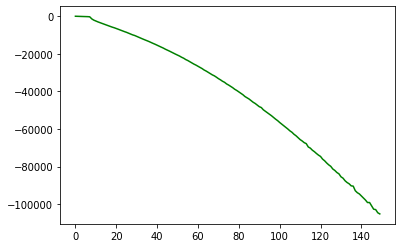

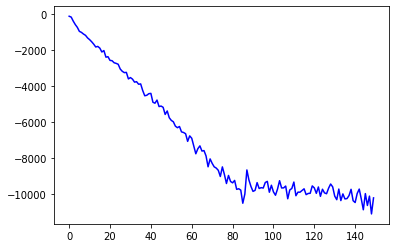

In [82]:
c.fit(150,30)

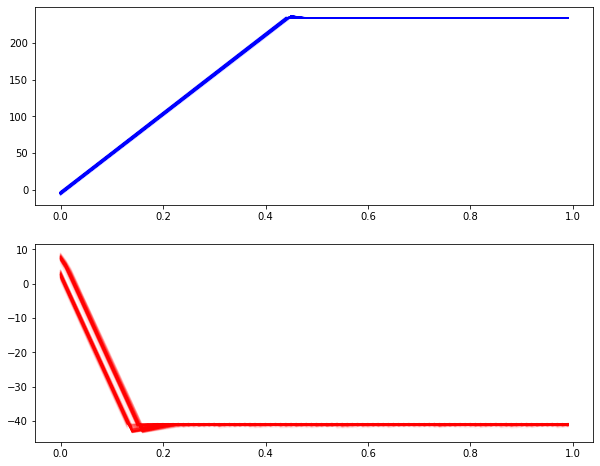

In [83]:
fig, axs = plt.subplots(2,1,  sharey=False, figsize=(10,8))


bb = lambda X, theta: -c.b_backward(X, theta)
t, Xts = c.sample_trajectory(X1,c.dt,  c.theta_f,  c.sigma, c.b_forward, c.number_time_steps, c.sde_solver)
for i in range(n):
    
    axs[0].plot(t.flatten(), Xts[i,...].flatten(), 'b', alpha=0.03, )
BXt = []   

t_, Xts_ = c.sample_trajectory(X2,c.dt,  c.theta_b,  c.sigma, bb, c.number_time_steps, c.sde_solver)
for i in range(n):
    
    BXt.append(Xt_[-1,:])
    axs[1].plot(t_.flatten(), Xts_[i,...].flatten(), 'r', alpha=0.03)


In [49]:
X22 = np.array(c.transport_batch( X1, True)).flatten()

In [50]:
X11 = np.array(c.transport_batch(X2, False)).flatten()

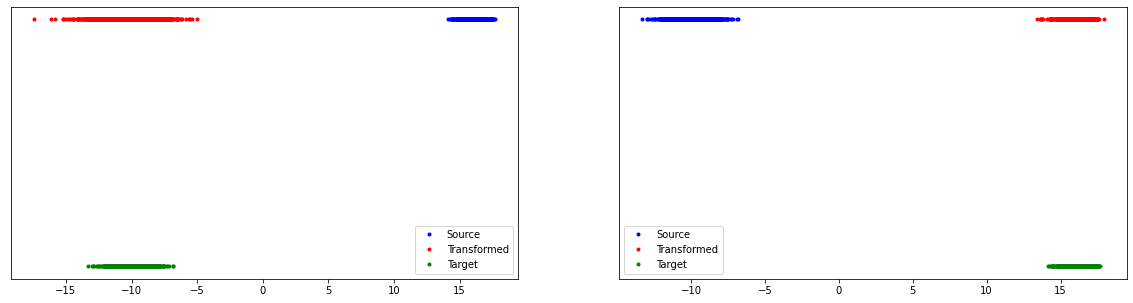

In [51]:
fig, axs = plt.subplots(1,2, figsize=(20,5))

axs[0].plot(X2.flatten(), [0] * n, 'b.', label="Source")
axs[0].plot(X11, [0] * n, 'r.', label="Transformed")
axs[0].plot(X1.flatten(), [-0.1] * n, 'g.', label="Target")
# axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].legend()

axs[1].plot(X1.flatten(), [0] * n, 'b.', label="Source")
axs[1].plot(X22, [0] * n, 'r.', label="Transformed")
axs[1].plot(X2.flatten(), [-0.1] * n, 'g.', label="Target")
# axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].legend()

In [604]:
batch_terminal_empirical_f = next(c.data_stream(forward=True))

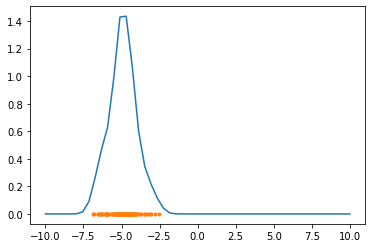

In [418]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_f, c.H_0))
plt.plot(xx, kd)
plt.plot(batch_terminal_empirical_f , [0] * len(batch_terminal_empirical_f), ".")

In [419]:
batch_terminal_empirical_b = next(c.data_stream(False))

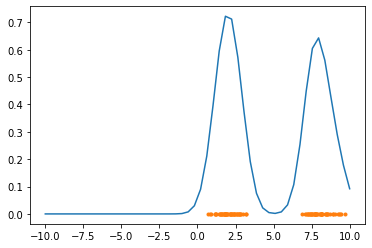

In [420]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd_b  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_b, c.H_1))
plt.plot(xx, kd_b)
plt.plot(batch_terminal_empirical_b , [0] * len(batch_terminal_empirical_b), ".")